In [1]:
from scipy.signal import hilbert, butter, filtfilt
from scipy.fftpack import fft,fftfreq,rfft,irfft,ifft
import urllib3
import logging
import numpy as np
import seaborn as sns
import pandas as pd
import scipy.stats as stats
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
sns.set_context('poster',font_scale=.8)
sns.set_style('whitegrid')
mpl.rc('figure',figsize=(15,2))

import warnings

# Desabilitar os avisos do tipo 'Retrying'
warnings.filterwarnings('ignore', 'Retrying', urllib3.exceptions.InsecureRequestWarning)
urllib3_logger = logging.getLogger('urllib3')
urllib3_logger.setLevel(logging.ERROR)

# Sincronização de fases instantânea entre duas séries temporais

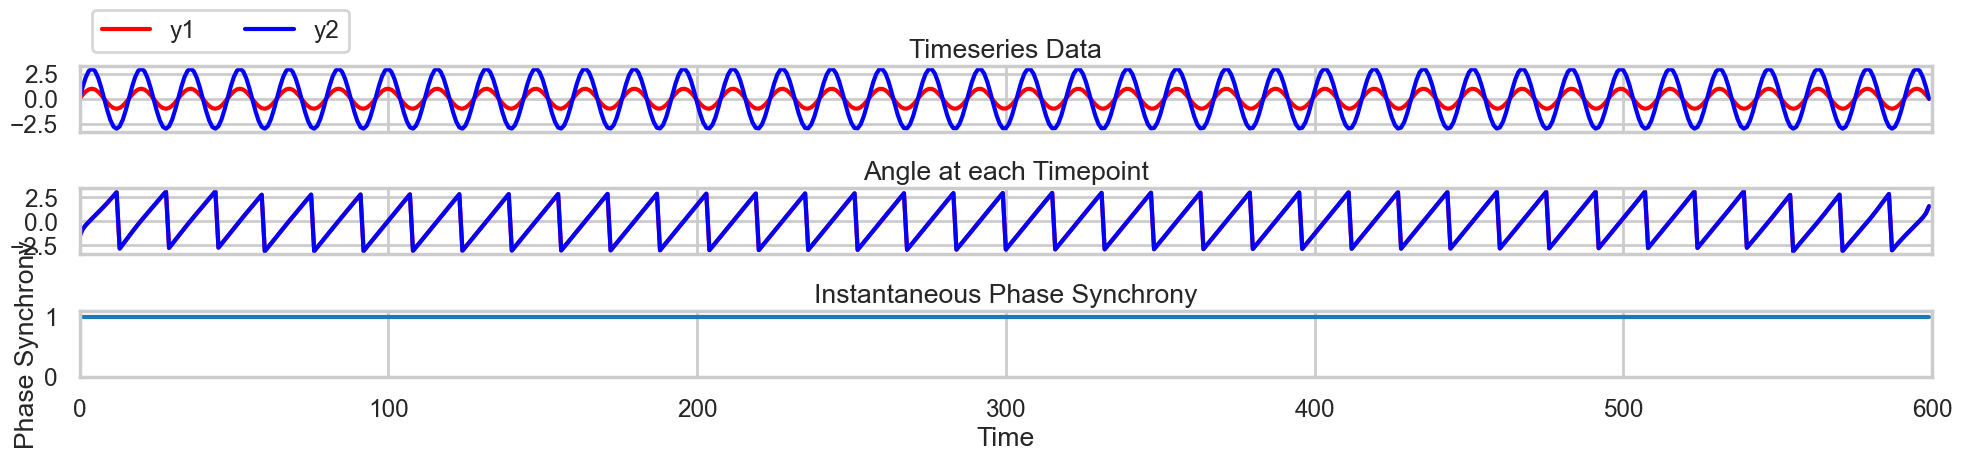

In [2]:
N = 600 # number of samples
T = 1.0 / 800.0 # sample spacing
x = np.linspace(0.0, N*T, N)
phase_y1, phase_y2 = 50., 50.
amp_y1, amp_y2 = 1.,3.
y1 = amp_y1*np.sin(phase_y1 * 2.0*np.pi*x)
y2 = amp_y2*np.sin(phase_y2 * 2.0*np.pi*x)
window=10
al1 = np.angle(hilbert(y1),deg=False)
al2 = np.angle(hilbert(y2),deg=False)
f,ax = plt.subplots(3,1,figsize=(20,5),sharex=True)
ax[0].plot(y1,color='r',label='y1')
ax[0].plot(y2,color='b',label='y2')
ax[0].legend(bbox_to_anchor=(0., 1.02, 1., .102),ncol=2)
ax[0].set(xlim=[0,N], title='Timeseries Data')
ax[1].plot(al1,color='r')
ax[1].plot(al2,color='b')
ax[1].set(title='Angle at each Timepoint')
phase_synchrony = 1-np.sin(np.abs(al1-al2)/2)
ax[2].plot(phase_synchrony)
ax[2].set(ylim=[0,1.1],xlim=[0,N],title='Instantaneous Phase Synchrony',xlabel='Time',ylabel='Phase Synchrony')
plt.tight_layout()
plt.show()

## Adicionando ruído

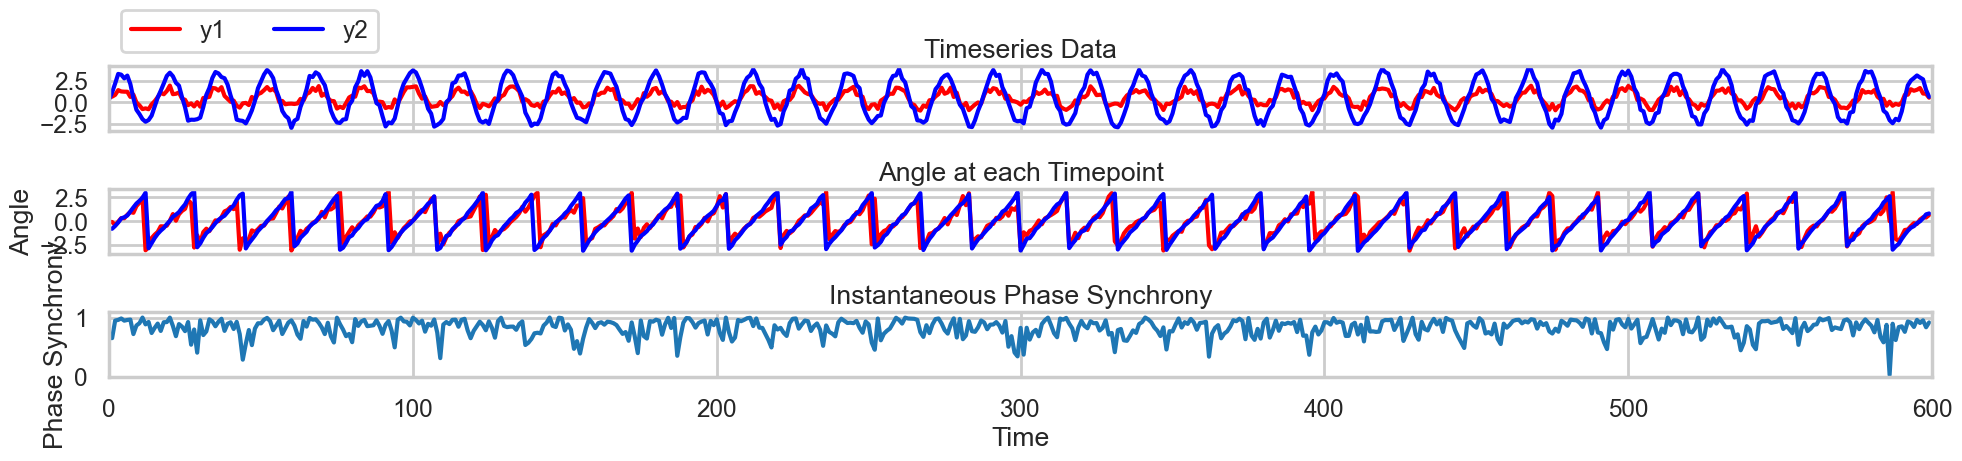

In [3]:
N = 600 # number of samples
T = 1.0 / 800.0 # sample spacing
x = np.linspace(0.0, N*T, N)
phase_y1, phase_y2 = 50., 50.
amp_y1, amp_y2 = 1.,3.
y1 = amp_y1*np.sin(phase_y1 * 2.0*np.pi*x)+np.random.rand(N)
y2 = amp_y2*np.sin(phase_y2 * 2.0*np.pi*x)+np.random.rand(N)
window=10
al1 = np.angle(hilbert(y1),deg=False)
al2 = np.angle(hilbert(y2),deg=False)
f,ax = plt.subplots(3,1,figsize=(20,5),sharex=True)
ax[0].plot(y1,color='r',label='y1')
ax[0].plot(y2,color='b',label='y2')
ax[0].legend(bbox_to_anchor=(0., 1.02, 1., .102),ncol=2)
ax[0].set(xlim=[0,N], title='Timeseries Data')
ax[1].plot(al1,color='r')
ax[1].plot(al2,color='b')
ax[1].set(ylabel='Angle',title='Angle at each Timepoint')
phase_synchrony = 1-np.sin(np.abs(al1-al2)/2)
ax[2].plot(phase_synchrony)
ax[2].set(ylim=[0,1.1],xlim=[0,N],title='Instantaneous Phase Synchrony',xlabel='Time',ylabel='Phase Synchrony')
plt.tight_layout()
plt.show()

## Aplicando às séries de soja grão e óleo

In [4]:
%pip install yahoofinancials
from yahoofinancials import YahooFinancials

Note: you may need to restart the kernel to use updated packages.


In [5]:
lista_codigos = ['ZS=F']  #soja grão
dados_yahoo = YahooFinancials(lista_codigos)
preco_diario = dados_yahoo.get_historical_price_data('1999-01-01', '2023-01-01', 'daily')
precos_soja = pd.DataFrame({a: {x['formatted_date']: x['adjclose'] for x in preco_diario[a]['prices']} for a in lista_codigos})

# Pré-processamento
precos_soja.reset_index(inplace=True)
precos_soja = precos_soja.rename(columns={'index':'Data'}).copy()
precos_soja.set_index('Data', inplace=True)
precos_soja.index = pd.to_datetime(precos_soja.index)

lista_codigos = ['ZL=F'] #oleo de soja
dados_yahoo = YahooFinancials(lista_codigos)
preco_diario = dados_yahoo.get_historical_price_data('1999-01-01', '2023-01-01', 'daily')
precos_oleo = pd.DataFrame({a: {x['formatted_date']: x['adjclose'] for x in preco_diario[a]['prices']} for a in lista_codigos})

# Pré-processamento
precos_oleo.reset_index(inplace=True)
precos_oleo = precos_oleo.rename(columns={'index':'Data'}).copy()
precos_oleo.set_index('Data', inplace=True)
precos_oleo.index = pd.to_datetime(precos_oleo.index)

# 1 bushel de soja = 60 libras
precos_oleo['ZL=F'] = precos_oleo['ZL=F'] * 60

#juntando as series de preços
precos = pd.merge(precos_soja, precos_oleo, left_index=True, right_index=True)

precos

TypeError: unsupported operand type(s) for -: 'datetime.datetime' and 'str'

In [ ]:
precos = precos.dropna(subset=['ZL=F', 'ZS=F'])  #apagar linhas com valores NaN
precos

,ZS=F,ZL=F
Data,,
2000-09-20,483.25,916.200027
2000-09-21,486.50,921.599979
2000-10-03,488.50,918.000011
2000-10-04,489.00,913.799973
2000-10-09,484.50,907.199993
...,...,...
2022-12-23,1479.00,3955.800018
2022-12-27,1482.25,4059.000092
2022-12-28,1506.50,3948.000183


In [ ]:
sojagrao = hilbert(precos['ZS=F'])
sojaoleo = hilbert(precos['ZL=F'])

In [ ]:
tam = len(sojagrao)
tam

5510

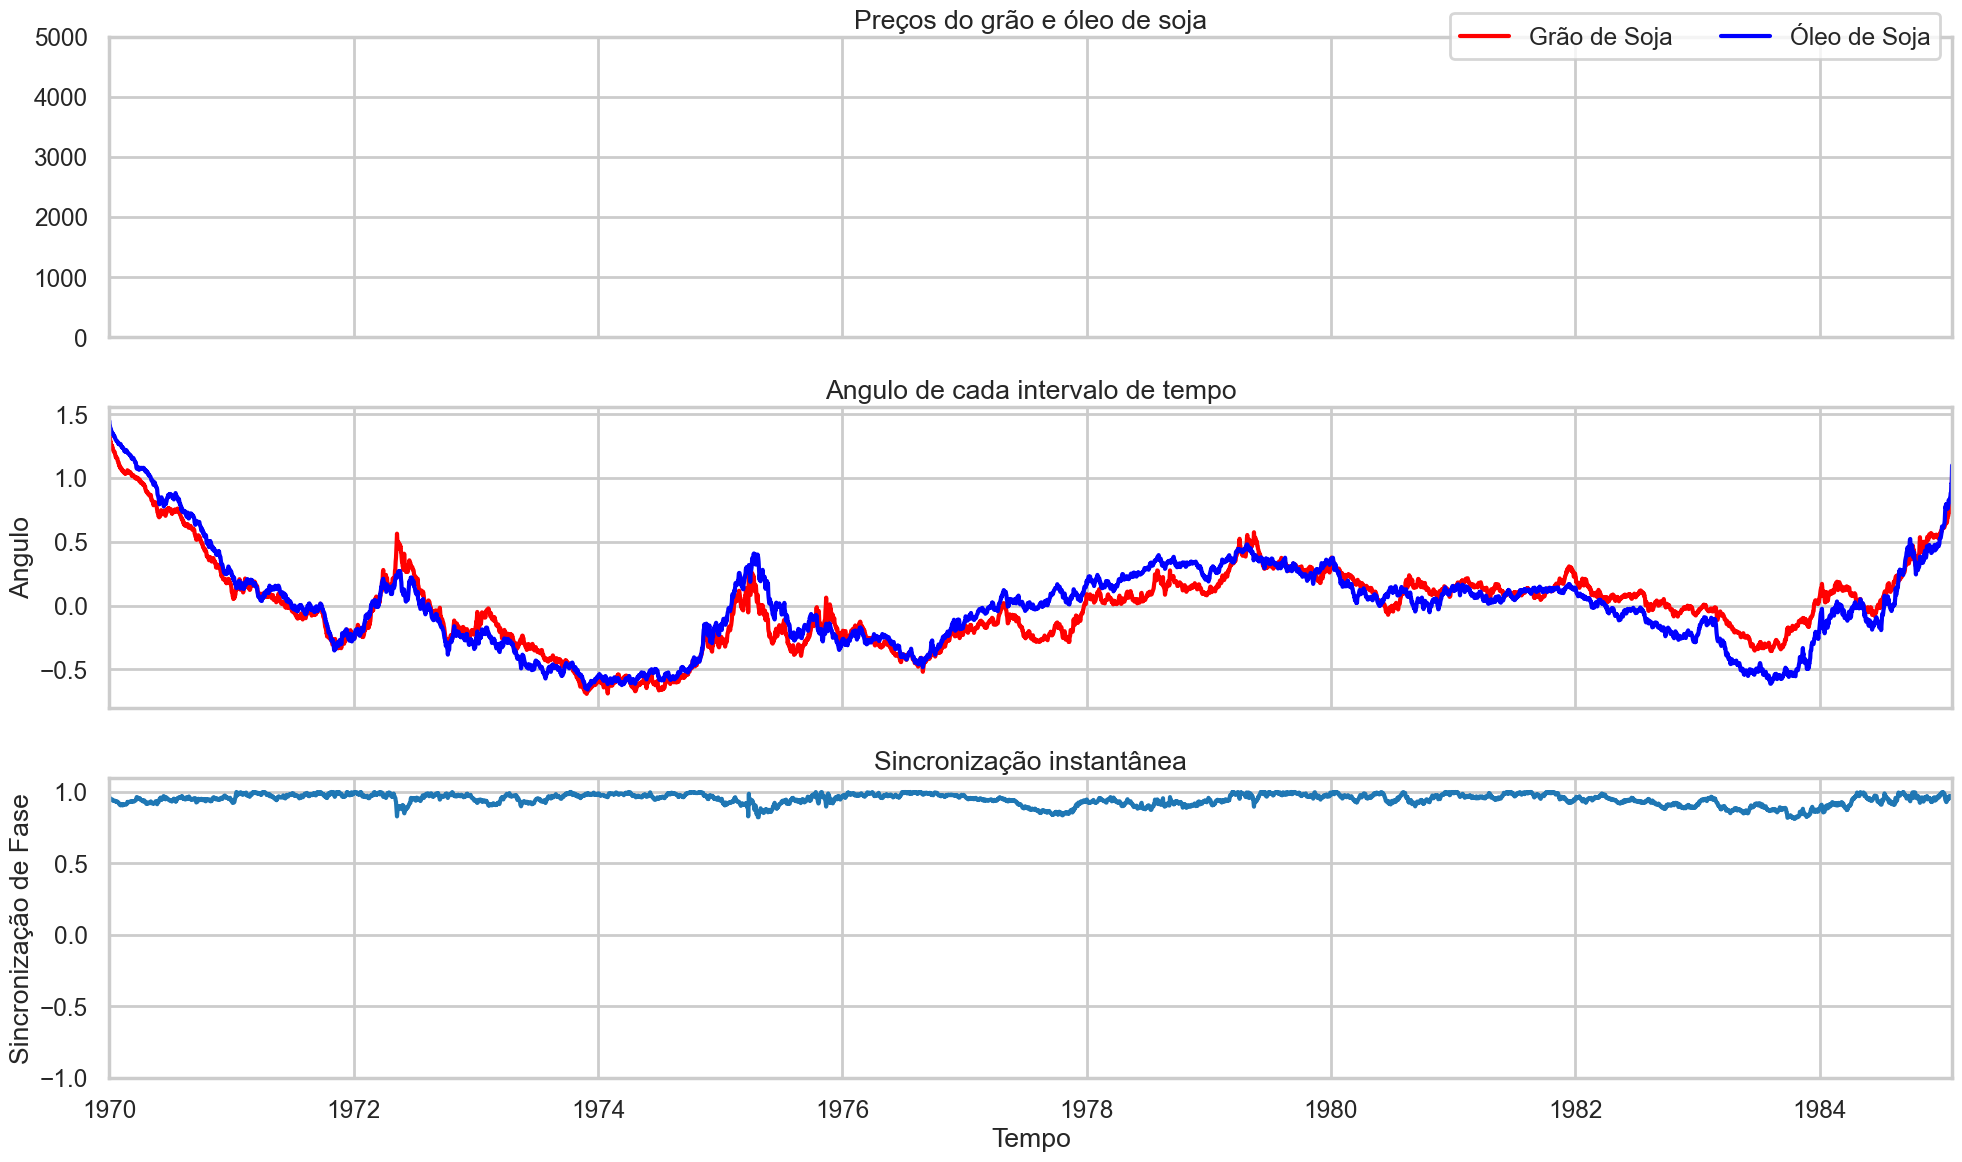

In [ ]:
#N = 600 # number of smaples
#T = 1.0 / 800.0 # sample spacing
#x = np.linspace(0.0, N*T, N)
#phase_y1, phase_y2 = 50., 50.
#amp_y1, amp_y2 = 1.,3.
#y1 = amp_y1*np.sin(phase_y1 * 2.0*np.pi*x)+np.random.rand(N)
#y2 = amp_y2*np.sin(phase_y2 * 2.0*np.pi*x)+np.random.rand(N)
#window=10
angulograo = np.angle(sojagrao,deg=False)
angulooleo = np.angle(sojaoleo,deg=False)
f,ax = plt.subplots(3,1,figsize=(20,12),sharex=True)
ax[0].plot(precos['ZS=F'],color='r',label='Grão de Soja')
ax[0].plot(precos['ZL=F'],color='b',label='Óleo de Soja')
ax[0].legend(bbox_to_anchor=(0., 1.02, 1., .102),ncol=2)
ax[0].set(ylim=[0,5000], xlim=[0,len(sojagrao)], title='Preços do grão e óleo de soja')
ax[1].plot(angulograo,color='r')
ax[1].plot(angulooleo,color='b')
ax[1].set(ylabel='Angulo',title='Angulo de cada intervalo de tempo')
sincronia = 1-np.sin(np.abs(angulograo-angulooleo)/2)
#sincronia = angulograo - angulooleo
ax[2].plot(sincronia)
ax[2].set(ylim=[-1,1.1],xlim=[0,len(sojagrao)],title='Sincronização instantânea',xlabel='Tempo',ylabel='Sincronização de Fase')
plt.tight_layout()
plt.show()

## Aplicando às séries de soja grão e farelo

In [ ]:
lista_codigos = ['ZMK24.CBT']  #ZMF está sem valores no momento (15/02/2024)
dados_yahoo = YahooFinancials(lista_codigos)
preco_diario = dados_yahoo.get_historical_price_data('1999-01-01', '2023-01-01', 'daily')
precos_farelo = pd.DataFrame({a: {x['formatted_date']: x['adjclose'] for x in preco_diario[a]['Prices']} for a in lista_codigos})

precos_farelo

KeyError: 'Prices'

<Axes: xlabel='Data'>

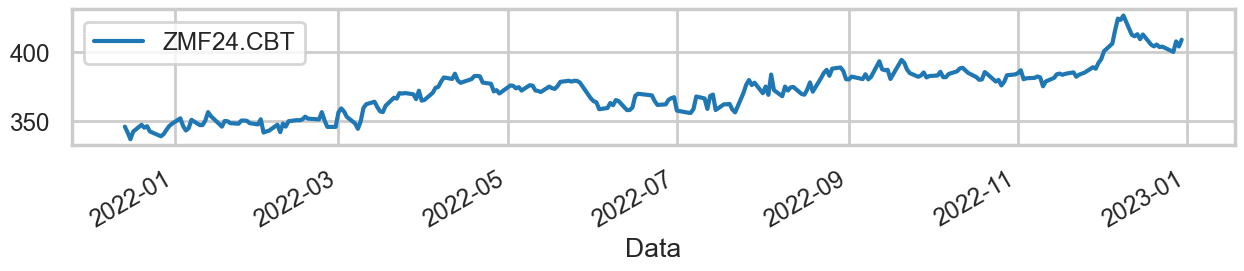

In [ ]:
#Pré-processamento
precos_farelo.reset_index(inplace=True)
precos_farelo = precos_farelo.rename(columns={'index':'Data'}).copy()
precos_farelo.set_index('Data', inplace=True)
precos_farelo.index = pd.to_datetime(precos_farelo.index)
precos_farelo.plot()

In [ ]:
precos = pd.merge(precos, precos_farelo, left_index=True, right_index=True)

precos

,ZS=F,ZL=F,ZMF24.CBT
Data,,,
2021-12-14,1259.50,3120.599899,345.899994
2021-12-15,1262.50,3208.200073,341.600006
2021-12-16,1277.25,3279.000092,336.799988
2021-12-17,1285.25,3232.800064,342.299988
2021-12-20,1292.25,3176.399918,347.200012
...,...,...,...
2022-12-23,1479.00,3955.800018,403.799988
2022-12-27,1482.25,4059.000092,400.000000
2022-12-28,1506.50,3948.000183,407.600006


In [ ]:
def STtoBushelSoy(st):
    bu_soja_lb = 60 # fator de conversão de bushel de soja para lb
    st_lb = 2000 # 1 tonelada curta (st) = 2000 libras (lb)

    valor = st / st_lb
    valor = valor * bu_soja_lb
    return valor

In [ ]:
precos["ZMF24.CBT"] = precos["ZMF24.CBT"].apply(STtoBushelSoy)
precos["ZMF24.CBT"]

Data
2021-12-14    10.377
2021-12-15    10.248
2021-12-16    10.104
2021-12-17    10.269
2021-12-20    10.416
               ...  
2022-12-23    12.114
2022-12-27    12.000
2022-12-28    12.228
2022-12-29    12.117
2022-12-30    12.264
Name: ZMF24.CBT, Length: 264, dtype: float64

In [ ]:
sojafarelo = hilbert(precos["ZMF24.CBT"])
sojagrao = hilbert(precos["ZS=F"])
sojaoleo = hilbert(precos["ZL=F"])

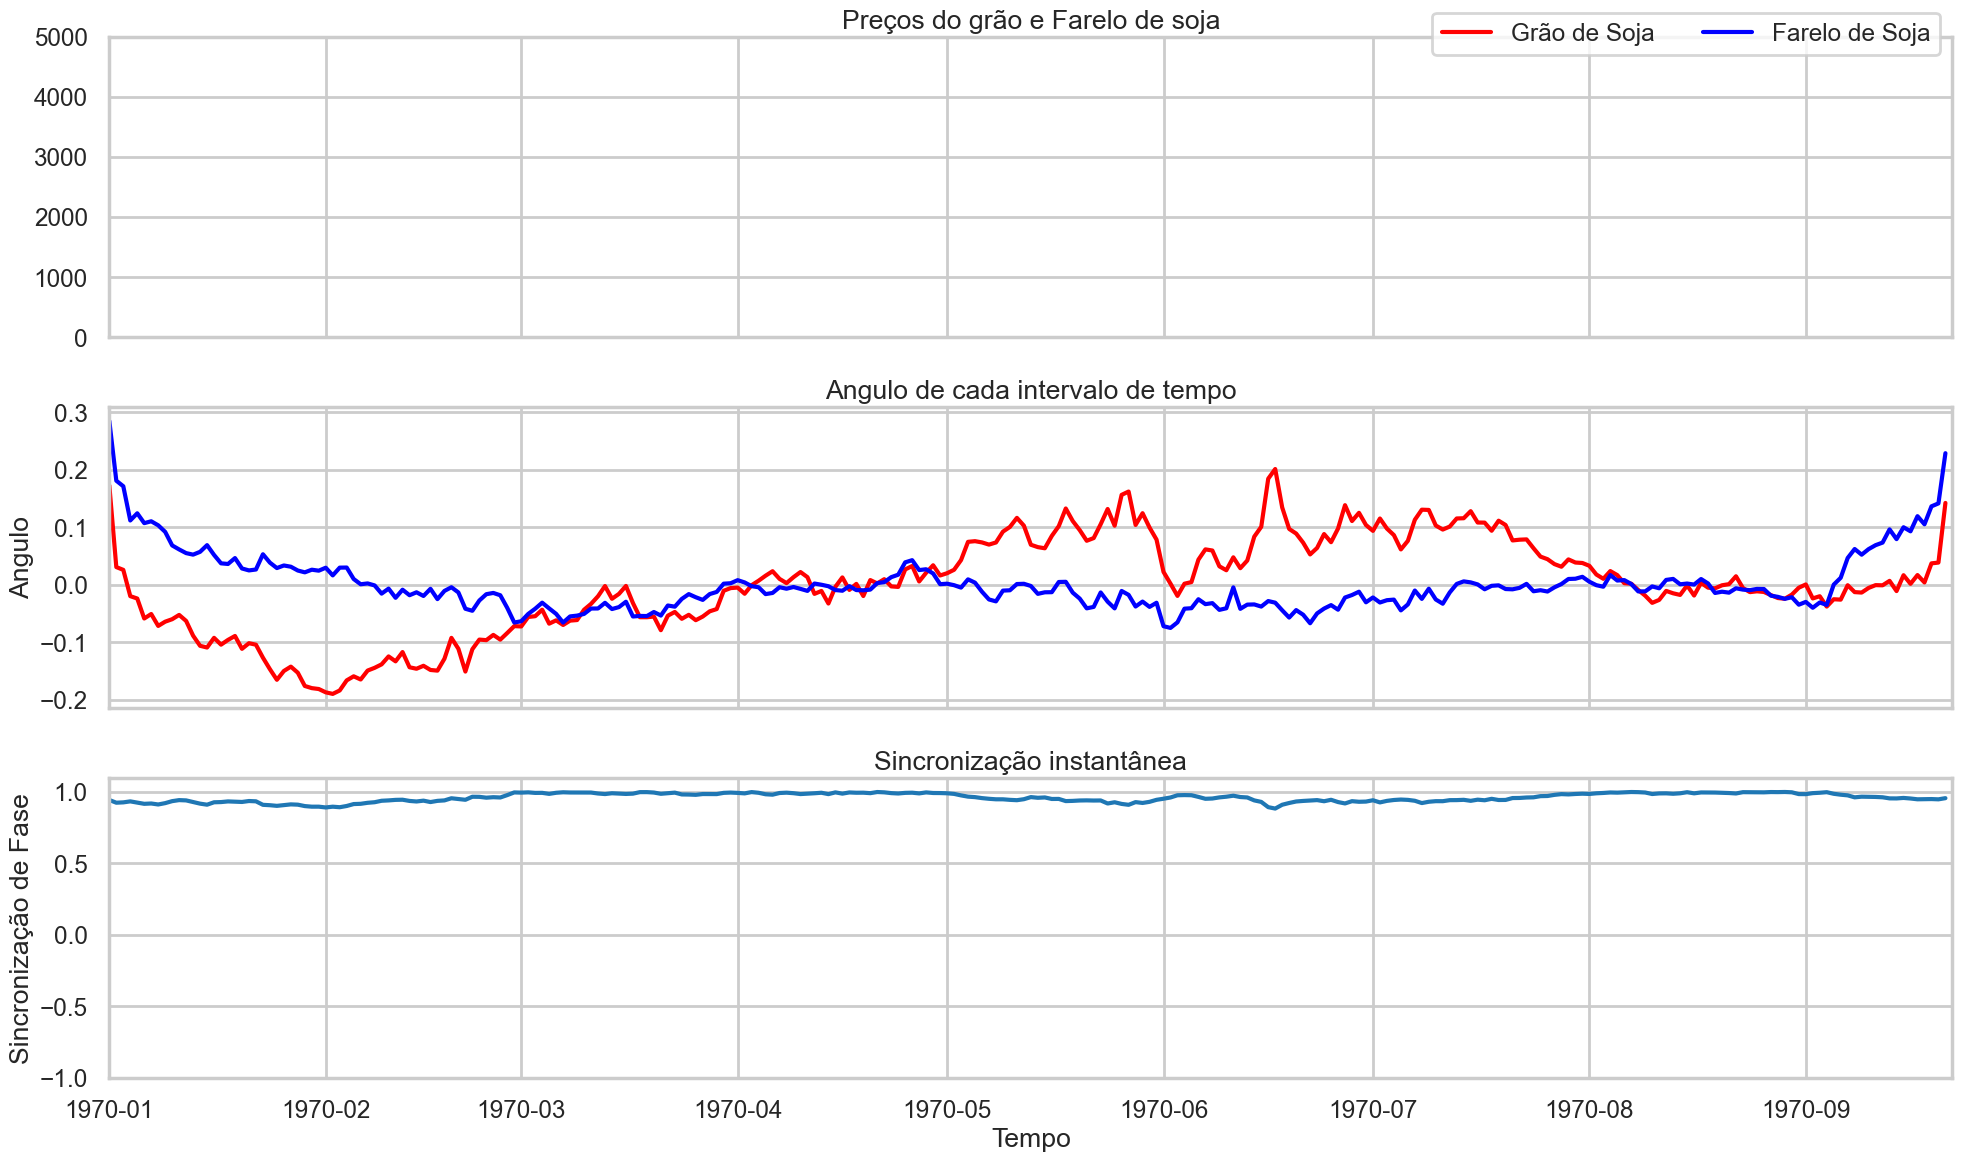

In [ ]:
angulograo = np.angle(sojagrao,deg=False)
angulofarelo = np.angle(sojafarelo,deg=False)
f,ax = plt.subplots(3,1,figsize=(20,12),sharex=True)
ax[0].plot(precos['ZS=F'],color='r',label='Grão de Soja')
ax[0].plot(precos["ZMF24.CBT"],color='b',label='Farelo de Soja')
ax[0].legend(bbox_to_anchor=(0., 1.02, 1., .102),ncol=2)
ax[0].set(ylim=[0,5000], xlim=[0,len(sojagrao)], title='Preços do grão e Farelo de soja')
ax[1].plot(angulograo,color='r')
ax[1].plot(angulofarelo,color='b')
ax[1].set(ylabel='Angulo',title='Angulo de cada intervalo de tempo')
sincronia = 1-np.sin(np.abs(angulograo-angulofarelo)/2)
#sincronia = angulograo - angulofarelo
ax[2].plot(sincronia)
ax[2].set(ylim=[-1,1.1],xlim=[0,len(sojagrao)],title='Sincronização instantânea',xlabel='Tempo',ylabel='Sincronização de Fase')
plt.tight_layout()
plt.show()

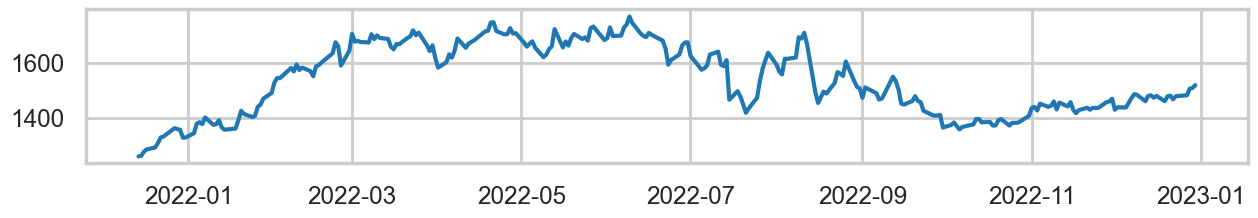

In [ ]:
plt.plot(precos["ZS=F"])

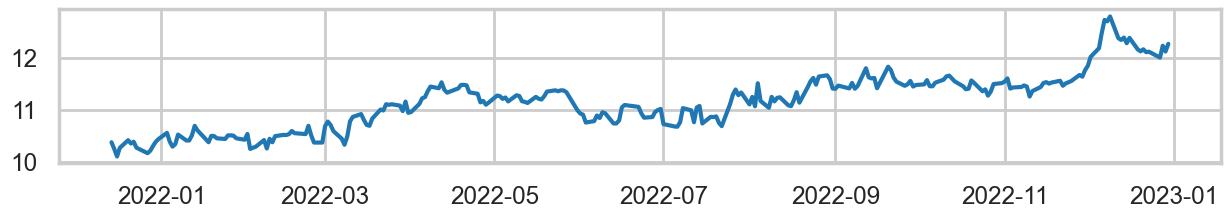

In [ ]:
plt.plot(precos["ZMF24.CBT"])

## Aplicando às séries de óleo e farelo

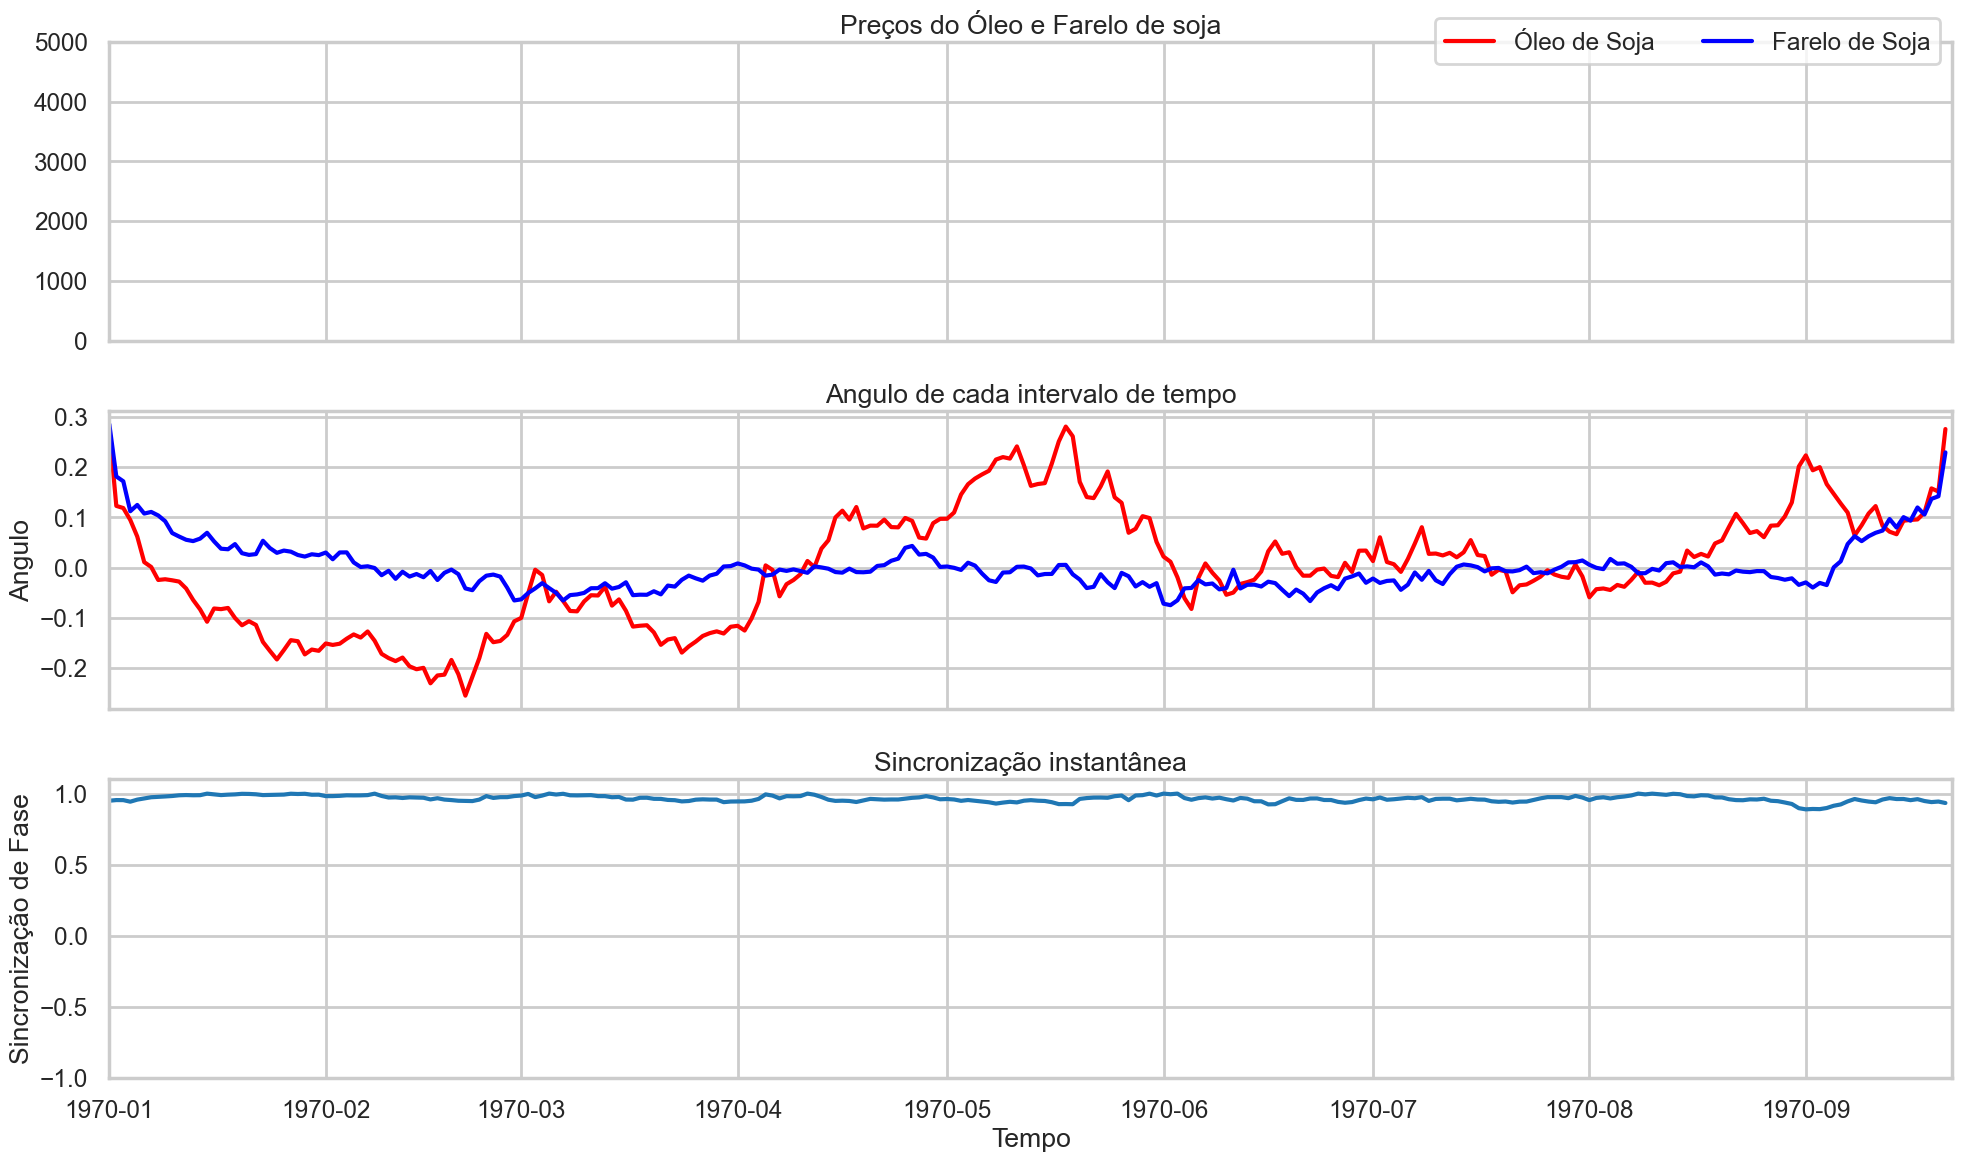

In [ ]:
angulooleo = np.angle(sojaoleo,deg=False)
angulofarelo = np.angle(sojafarelo,deg=False)
f,ax = plt.subplots(3,1,figsize=(20,12),sharex=True)
ax[0].plot(precos['ZL=F'],color='r',label='Óleo de Soja')
ax[0].plot(precos["ZMF24.CBT"],color='b',label='Farelo de Soja')
#ax[0].legend(bbox_to_anchor=(0., 1.02, 1., .102),ncol=2)
ax[0].set(ylim=[0,5000], xlim=[0,len(sojaoleo)], title='Preços do Óleo e Farelo de soja')
ax[1].plot(angulooleo,color='r')
ax[1].plot(angulofarelo,color='b')
ax[1].set(ylabel='Angulo',title='Angulo de cada intervalo de tempo')
sincronia = 1-np.sin(np.abs(angulograo-angulooleo)/2)
#sincronia = angulooleo - angulofarelo
ax[2].plot(sincronia)
ax[2].set(ylim=[-1,1.1],xlim=[0,len(sojaoleo)],title='Sincronização instantânea',xlabel='Tempo',ylabel='Sincronização de Fase')
plt.tight_layout()
plt.show()